<a href="https://colab.research.google.com/github/liamchalcroft/RectAngle/blob/main/colab_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for basic prototyping of work before porting to full script for testing

Note: Try importing lambda layer

In [9]:
! git clone https://49064dc98b2d46c3874378ed4375bf1b5938d905@github.com/liamchalcroft/RectAngle.git

Cloning into 'RectAngle'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [23]:
! python ./RectAngle/data.py

Done.
Image and label data downloaded: dataset70-200.h5
  with 200 cases with a total of 5346 frames and 16038 labels.

How many example frames would you like to visualise, e.g. 10?
10


In [24]:
! ls

case0001.jpg  case0063.jpg  case0142.jpg  case0183.jpg	    sample_data
case0020.jpg  case0104.jpg  case0153.jpg  dataset70-200.h5
case0029.jpg  case0137.jpg  case0182.jpg  RectAngle


In [46]:
import h5py
import matplotlib.pyplot as plt
from torch import nn
import torch

In [25]:
f = h5py.File('dataset70-200.h5', 'r')

In [28]:
keys_ = list(f.keys())

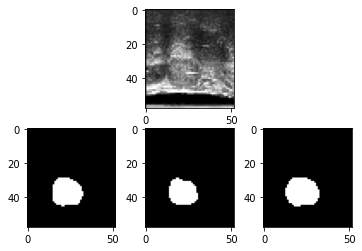

In [42]:
plt.figure()
plt.subplot(2,3,2)
plt.imshow(f['frame_0000_000'], cmap='gray')
plt.subplot(2,3,4)
plt.imshow(f['label_0000_000_00'], cmap='gray')
plt.subplot(2,3,5)
plt.imshow(f['label_0000_000_01'], cmap='gray')
plt.subplot(2,3,6)
plt.imshow(f['label_0000_000_02'], cmap='gray')
plt.show()

In [92]:
class UNet(nn.Module):
  def __init__(self, ch_in=1, ch_out=1,
               first_layer=16, n_layers=4):
    
    super().__init__()
    
    enc_list = []
    down_list = []

    enc_list.append(UNet.UNetBlock(ch_in, first_layer))
    down_list.append(nn.MaxPool2d(kernel_size=2, stride=2))

    for i in range(n_layers-1):
      enc_list.append(UNet.UNetBlock(first_layer*(2**i), 
                                          first_layer*(2**(i+1))
                                          ))
      down_list.append(nn.MaxPool2d(kernel_size=2, stride=2))

    self.enc_list = nn.ModuleList(enc_list)
    self.down_list = nn.ModuleList(down_list)
      
    self.bottleneck = UNet.UNetBlock(first_layer*(2**(n_layers-1)),
                                     first_layer*(2**(n_layers))
                                     )

    dec_list = []
    up_list = []

    # dec_list.append(UNet.UNetBlock(first_layer*(2**(n_layers)),
    #                                first_layer*(2**(n_layers-1))))

    for i in range(n_layers):
      up_list.append(nn.ConvTranspose2d(first_layer*(2**(n_layers-(i))), 
                                        first_layer*(2**(n_layers-(i+1))), 
                                        kernel_size=2, stride=2))
      dec_list.append(UNet.UNetBlock(first_layer*(2**(n_layers-(i))), 
                                     first_layer*(2**(n_layers-(i+1)))
                                     ))
      
    self.dec_list = nn.ModuleList(dec_list)
    self.up_list = nn.ModuleList(up_list)
      
    self.head = nn.Conv2d(in_channels=first_layer, out_channels=ch_out, 
                          kernel_size=1)
    
  def forward(self, x):
    enc_features = []
    for i in range(len(self.enc_list)):
      x = self.enc_list[i](x)
      enc_features.append(x)
      x = self.down_list[i](x)
    
    x = self.bottleneck(x)

    enc_features = enc_features[::-1]

    for i in range(len(self.dec_list)):
      x = self.up_list[i](x)
      x = torch.cat((x, enc_features[i]), dim=1)
      x = self.dec_list[i](x)

    x = self.head(x)
    
    return torch.sigmoid(x)

  @staticmethod
  def UNetBlock(ch_in, n_feat):
    return torch.nn.Sequential(
        nn.Conv2d(in_channels=ch_in, out_channels=n_feat, 
                  kernel_size=3, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=n_feat),
        nn.Conv2d(in_channels=n_feat, out_channels=n_feat, 
                  kernel_size=3, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=n_feat)
        )


In [93]:
model = UNet()

In [94]:
print(model)

UNet(
  (enc_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=T

In [104]:
in_test = torch.randn(1,1,256,256)

In [105]:
out_test = model(in_test)

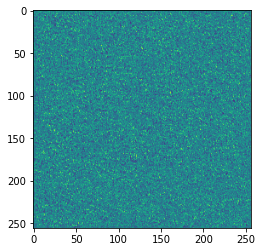

In [106]:
plt.imshow(out_test[0,0].detach().numpy())